### To Do List
- See how many accidents are exact fits after snapping

#### Finally
- Add documentation
- Plot network with time information
- Complete other investigative work for Task B
- Begin and complete Task C

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import random
import folium
import pyproj
import numpy as np
import requests
import shapely.geometry
import os
import pandas as pd
import glob
from IPython.display import clear_output
from datetime import timedelta
import time
# Some new libraries: they should already
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import box, Point, LineString
import spaghetti
import math
import pyproj
import esda
import seaborn as sns

/home/k21195339/.local/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
def distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance (in meters) between two points on the Earth's surface
    given their latitude and longitude coordinates using the Haversine formula.
    """
    R = 6371000  # radius of the Earth in meters
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))

    return R*c

In [3]:
def point_in_bbox(point):
    N, S, E, W = leeds_bbox
    lat, lon = point

    if N >= lat >= S and E >= lon >= W:
        return True
    else:
        return False

## Task A (spatial networks and planarity):

In this task, you construct and investigate the road network. You are asked to choose an area of roughly 1 square kilometre around the centre of Leeds for your analysis. You should look for an area where a significant number of the recorded road accidents occurred in the area, e.g. 300 or more total across multiple years, and show you have tested this in your report. You only need to consider roads used for driving, not walking paths or private roads (investigate the osmnx documentation for how you might do this filtering). Your report should give the coordinates of the area chosen. You should then answer the following questions:

1.     What are the characteristics of this road network? Include, at least, the spatial diameter of the network, the average street length, node density, intersection density, and edge density.

2.     What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?

3.     Is the network planar? Why/why not?

In [4]:
center_lat = 53.802035
center_lon = -1.537810

In [5]:
center_lat = 53.802035
center_lon = -1.537810
# 53.802035, -1.537810
# 53.785131, -1.549249
# 53.799023, -1.540866
# 53.8008, -1.5491
# 53.800777, -1.538732

# Define the center point of Leeds
leeds_center = (center_lat, center_lon)

# Create the graph for Leeds city center
leeds_graph = ox.graph.graph_from_point(leeds_center, dist=500, dist_type='bbox', network_type='drive')
# Get the bounding box
leeds_bbox = ox.utils_geo.bbox_from_point(leeds_center, dist=500)
# Create a polygon - use it later
leeds_polygon = ox.utils_geo.bbox_to_poly(leeds_bbox[0], leeds_bbox[1], leeds_bbox[2], leeds_bbox[3])
# Find the Area
base = distance(leeds_bbox[0], leeds_bbox[2], leeds_bbox[0], leeds_bbox[3])
height = distance(leeds_bbox[0], leeds_bbox[3], leeds_bbox[1], leeds_bbox[3])
leeds_area = base*height

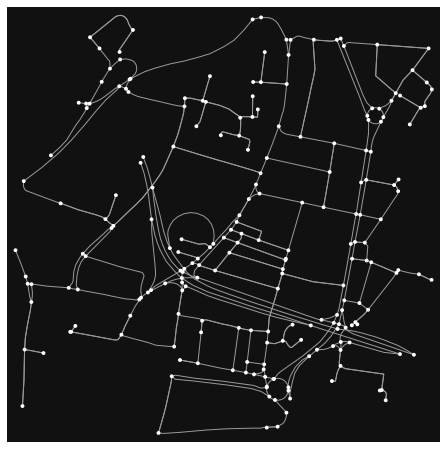

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
ox.plot_graph(leeds_graph)

In [7]:
ox.plot_graph_folium(leeds_graph)

1.     What are the characteristics of this road network? Include, at least, the spatial diameter of the network, the average street length, node density, intersection density, and edge density.

2.     What is the average circuitry of the network? What does this tell you about the efficiency of using roads in this area?


In [8]:
# Calculate Basic Stats
basic_stats = ox.stats.basic_stats(leeds_graph, area=leeds_area)

# Spatial Diameter

# Average Street Length
print("Average street length: {}m".format(round(basic_stats["street_length_avg"], 2)))

# Node Density
print("Node density of {} nodes per square km".format(basic_stats["n"]))

# Intersection Density
print("Intersection density of {} intersections per square km".format(basic_stats["intersection_count"]))

# Edge Density
print("Edge density of {} edges per square km".format(basic_stats["edge_density_km"]))

Average street length: 65.49m
Node density of 217 nodes per square km
Intersection density of 190 intersections per square km
Edge density of 24580.39851509654 edges per square km


In [9]:
for m in basic_stats:
    print("{}: {}".format(m, basic_stats[m]))

n: 217
m: 386
k_avg: 3.557603686635945
edge_length_total: 24577.693000000014
edge_length_avg: 63.67277979274615
streets_per_node_avg: 2.8202764976958523
streets_per_node_counts: {0: 0, 1: 27, 2: 12, 3: 151, 4: 27}
streets_per_node_proportions: {0: 0.0, 1: 0.12442396313364056, 2: 0.055299539170506916, 3: 0.695852534562212, 4: 0.12442396313364056}
intersection_count: 190
street_length_total: 18731.113000000005
street_segment_count: 286
street_length_avg: 65.49340209790212
circuity_avg: 1.0303846733857918
self_loop_proportion: 0.0
node_density_km: 217.02388738340684
intersection_density_km: 190.02091522049446
edge_density_km: 24580.39851509654
street_density_km: 18733.174922939488


In [10]:
is_planar, kuratowski_subgraphs = nx.check_planarity(leeds_graph, counterexample=True)
is_planar

False

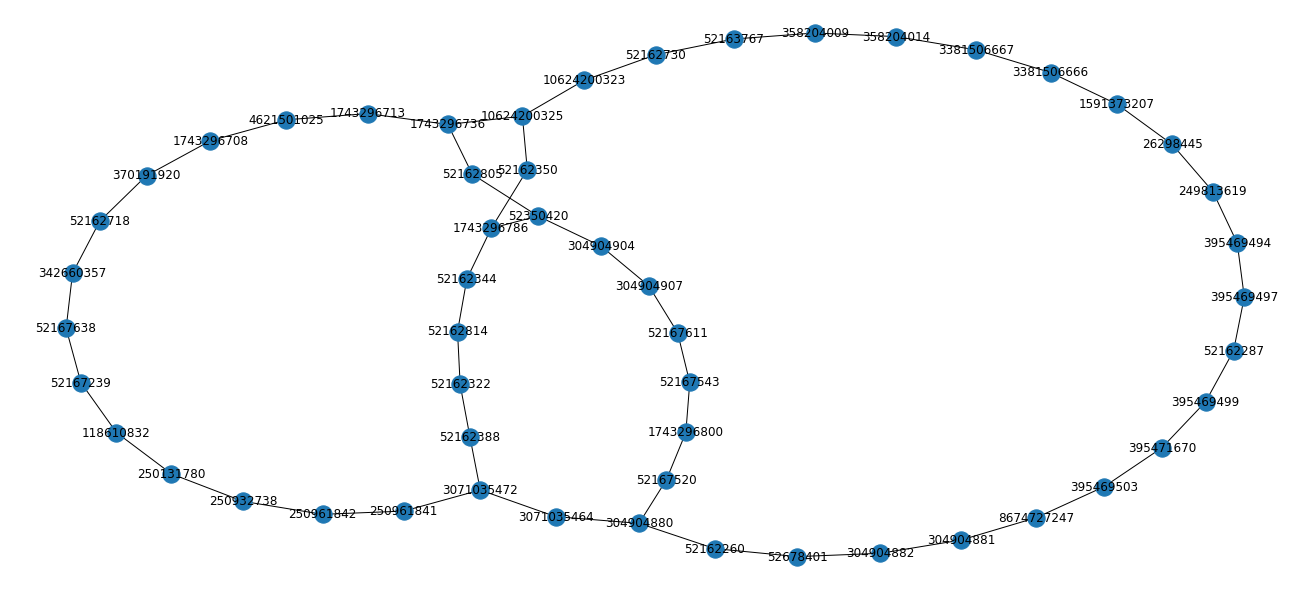

In [11]:
plt.figure(figsize=(18, 8))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, arrowstyle='-|>', with_labels=True)
plt.show()

In [12]:
# get the spatial diameter of the network (longest shortest path between any two nodes)
diameter = ox.extended_stats(leeds_graph).get('diameter')
print("Spatial diameter of the network:", diameter, "meters")

# get the average street length
avg_street_length = ox.basic_stats(leeds_graph).get('avg_edge_length')
print("Average street length:", avg_street_length, "meters")

# get the node density (number of nodes per square kilometer)
node_density = ox.basic_stats(leeds_graph, area=1000000).get('n') / 1000000
print("Node density:", node_density, "nodes per square kilometer")

# get the intersection density (number of intersections per square kilometer)
intersection_density = ox.basic_stats(leeds_graph, area=1000000).get('intersection_count') / 1000000
print("Intersection density:", intersection_density, "intersections per square kilometer")

# get the edge density (number of edges per square kilometer)
edge_density = ox.basic_stats(leeds_graph, area=1000000).get('m') / 1000000
print("Edge density:", edge_density, "edges per square kilometer")

# get the average circuitry (ratio of network length to straight-line distance between nodes)
avg_circuitry = ox.basic_stats(leeds_graph).get('circuity_avg')
print("Average circuitry of the network:", avg_circuitry)

if is_planar:
    print("The network is planar.")
else:
    print("The network is not planar.")

/home/k21195339/.local/lib/python3.8/site-packages/osmnx/stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


Spatial diameter of the network: None meters
Average street length: None meters
Node density: 0.000217 nodes per square kilometer
Intersection density: 0.00019 intersections per square kilometer
Edge density: 0.000386 edges per square kilometer
Average circuitry of the network: 1.0303846733857918
The network is not planar.


## Task B (Road Accidents):

In this task, you should investigate the road accidents on the road network.

1.     Plot the distribution of road accidents on your road network and visualise this. Aggregate across multiple years of accident data. You do not need to consider or represent when the accidents happened, only their location; but you are welcome to add information about time if you believe there is something interesting to show.

2.     Investigate whether a high number of accidents on one road correlates with a high number on connecting roads.

3.     Investigate whether accidents happen nearer to intersections or partway along roads. Consider this as asking at what fraction of the road length away from the nearest intersection do accidents typically occur.

For the above, we suggest using the spaghetti library as shown in your lessons. The third question will require investigating the API of the library to find the relevant functions to answer the question.

In [13]:
# Here, I assume that you downloaded or moved the crime data in `../data/crimes/`
ACCIDENTS_DIR = "data"  # then, one subfolder for each YEAR-MONTH
# We will only use the longitude and latitude columns in the data
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing', 'Accident Date']

# We need to load and collate all CSV files into a single dataframe
years_df = [pd.read_csv(csv_file, usecols=USE_COLS, encoding='iso-8859-1') \
                for path, subdir, _ in os.walk(ACCIDENTS_DIR) \
                 for csv_file in glob.glob(os.path.join(path, "*.csv"))]

print("Found {} CSV files in {}".format(len(years_df), ACCIDENTS_DIR))

accidents_df = pd.concat(years_df, axis=0, ignore_index=True)
print("Total no. of accidents loaded: {}".format(len(accidents_df)))

# Some accide do not record a location, so drop any that have 'NaN' for the longitude or latitude
located_accidents = accidents_df.dropna(subset=USE_COLS)
print("Total no. of located accidents filtered: {}".format(len(located_accidents)))

Found 7 CSV files in data
Total no. of accidents loaded: 16284
Total no. of located accidents filtered: 16284


In [14]:
located_accidents.rename(columns={"Accident Date": "Accident Year"}, inplace=True)
located_accidents['Accident Year'] = ('20' + located_accidents['Accident Year'].str[-2:]).astype(int)  
located_accidents.sort_values(by="Accident Year", inplace=True)
located_accidents

Grid Ref: Easting  Grid Ref: Northing  Accident Year
7165             430104              433928           2013
6011             419870              438909           2013
6010             427984              435224           2013
6009             429832              438889           2013
6008             420676              445078           2013
...                 ...                 ...            ...
8908             428804              433315           2019
8909             431402              435029           2019
8910             441099              432504           2019
8898             429962              430875           2019
8141             429816              434406           2019

[16284 rows x 3 columns]

In [15]:
# Translate to a GeoDatFrame where the geometry is given by a Point constructed from the longitude and latitude
accident_points = GeoDataFrame(located_accidents["Accident Year"], geometry=[Point(xy) for xy in zip(
    located_accidents["Grid Ref: Easting"], located_accidents["Grid Ref: Northing"])])

# define the input and output CRS
input_crs = "EPSG:27700"
output_crs = 'EPSG:4326' # WGS 84, the most common CRS for latitude and longitude

# create a PyProj transformer to convert between the CRSs
transformer = pyproj.Transformer.from_crs(input_crs, output_crs)

# apply the transformer to the POINT geometry column
accident_points['lonlat'] = accident_points['geometry'].apply(lambda geom: transformer.transform(geom.x, geom.y))

# replace the 'geometry' column with the new 'lonlat' column
accident_points['geometry'] = accident_points['lonlat'].apply(lambda lonlat: Point(lonlat[1], lonlat[0]))

accident_points['in_bbox'] = accident_points.apply(lambda row: point_in_bbox(row["lonlat"]), axis=1)

accident_points

Accident Year                   geometry  \
7165           2013  POINT (-1.54442 53.80079)   
6011           2013  POINT (-1.69948 53.84605)   
6010           2013  POINT (-1.57649 53.81255)   
6009           2013  POINT (-1.54807 53.84539)   
6008           2013  POINT (-1.68681 53.90146)   
...             ...                        ...   
8908           2019  POINT (-1.56421 53.79535)   
8909           2019  POINT (-1.52460 53.81061)   
8910           2019  POINT (-1.37768 53.78724)   
8898           2019  POINT (-1.54687 53.77336)   
8141           2019  POINT (-1.54874 53.80510)   

                                         lonlat  in_bbox  
7165   (53.80078843899443, -1.5444171895231136)     True  
6011   (53.84604585585802, -1.6994754709650017)    False  
6010   (53.81255436644005, -1.5764864936620746)    False  
6009   (53.84539171690369, -1.5480674945030963)    False  
6008  (53.901459740552575, -1.6868115010987748)    False  
...                                         ...      ...  
8908    (53.7953522868958, -1.5642113215531406)    False  
8909  (53.810607391779605, -1.5245987288349254)    False  
8910   (53.787240452810984, -1.377680688438386)    False  
8898  (53.773357185751856, -1.5468686764731132)    False  
8141   (53.80510106461298, -1.5487435976217845)    False  

[16284 rows x 4 columns]

In [16]:
leeds_accidents = accident_points[accident_points["in_bbox"] == True]
leeds_accidents = leeds_accidents.drop(columns=["lonlat"])
leeds_accidents.sort_values(by="Accident Year")
leeds_accidents

Accident Year                   geometry  in_bbox
7165           2013  POINT (-1.54442 53.80079)     True
6099           2013  POINT (-1.53553 53.80553)     True
5855           2013  POINT (-1.54368 53.80255)     True
5846           2013  POINT (-1.53522 53.79767)     True
5932           2013  POINT (-1.53054 53.79958)     True
...             ...                        ...      ...
9028           2019  POINT (-1.53314 53.80168)     True
9017           2019  POINT (-1.53314 53.80168)     True
8837           2019  POINT (-1.53051 53.80584)     True
8839           2019  POINT (-1.53273 53.80338)     True
8884           2019  POINT (-1.54087 53.80056)     True

[457 rows x 3 columns]

In [17]:
# Some edges (roads in Soho) are missing a geometry, so we will create one
# assuming that the road is a direct line from start point to end point.
# First, we need to get the locations of the points
x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# We will work with the edges and add the missing geometries (lines denoting the roads between points)
graph_with_geometries = list(leeds_graph.edges(data=True))

# Iterate through the edges and, where missing, add a geometry attribute with the line between start and end nodes
for e in graph_with_geometries:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([
            Point(x_values[e[0]], y_values[e[0]]),
            Point(x_values[e[1]], y_values[e[1]])])

# We will now drop the start and end nodes, as we will construct a new Spaghetti network based on the geometries of the roads
road_lines = [x[2] for x in graph_with_geometries]
# From this, we can construct a GeoDataFrame
roads_geodataframe = GeoDataFrame(pd.DataFrame(road_lines))
# From the GeoDataFrame, we can construct a network in Spaghetti from which to do point analysis
leeds_points_graph = spaghetti.Network(in_data=roads_geodataframe)

<AxesSubplot:>

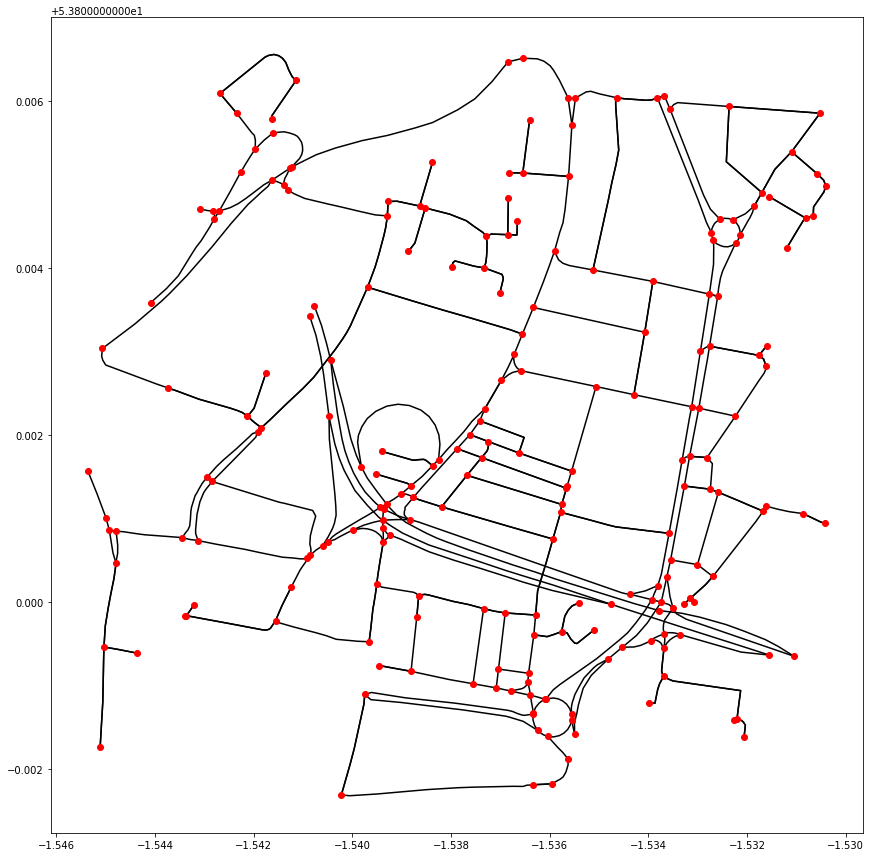

In [18]:
# Check what this new network looks like by getting DataFrames for the edges and plotting them
#nodes_df, edges_df = spaghetti.element_as_gdf(
#    leeds_points_graph, vertices=True, arcs=True)
# Convert the graph to GeoDataFrames of nodes and edges
nodes_df, edges_df = ox.graph_to_gdfs(leeds_graph)
base_network = edges_df.plot(color = "k", zorder=0, figsize=(15, 15))
nodes_df.plot(ax=base_network, color="r", zorder=2)

In [19]:
nodes_df

y         x  street_count          highway  \
osmid                                                             
643907       53.798390 -1.536041             3              NaN   
643945       53.798838 -1.536077             3              NaN   
643946       53.798673 -1.536331             3              NaN   
643951       53.799456 -1.534532             3  traffic_signals   
9791699      53.799039 -1.536446             3              NaN   
...                ...       ...           ...              ...   
9755805529   53.797690 -1.540226             2              NaN   
10624200323  53.801134 -1.539435             4              NaN   
10624200325  53.801107 -1.539355             4              NaN   
10652870860  53.799837 -1.543398             1              NaN   
10652870861  53.799835 -1.543366             3   turning_circle   

                              geometry  
osmid                                   
643907       POINT (-1.53604 53.79839)  
643945       POINT (-1.53608 53.79884)  
643946       POINT (-1.53633 53.79867)  
643951       POINT (-1.53453 53.79946)  
9791699      POINT (-1.53645 53.79904)  
...                                ...  
9755805529   POINT (-1.54023 53.79769)  
10624200323  POINT (-1.53943 53.80113)  
10624200325  POINT (-1.53936 53.80111)  
10652870860  POINT (-1.54340 53.79984)  
10652870861  POINT (-1.54337 53.79984)  

[217 rows x 5 columns]

In [20]:
# We will now snap the Soho located crimes we extracted earlier, i.e. position them at the closest point on the closest road
leeds_points_graph.snapobservations(leeds_accidents, 'accidents')

# We can see the difference between the original crime coordinates and their position when snapped to the road network
print("observation 1\ntrue coords:\t%s\nsnapped coords:\t%s" % (
    leeds_points_graph.pointpatterns["accidents"].points[0]["coordinates"],
    leeds_points_graph.pointpatterns["accidents"].snapped_coordinates[0]
))

/home/k21195339/.local/lib/python3.8/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/k21195339/.local/lib/python3.8/site-packages/libpysal/cg/shapes.py:1006: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/home/k21195339/.local/lib/python3.8/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


observation 1
true coords:	(-1.5444171895231136, 53.80078843899443)
snapped coords:	(-1.5444143927357115, 53.80082030707588)


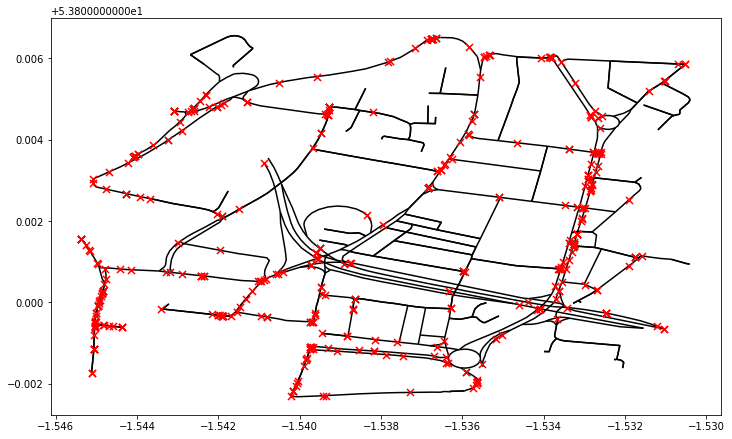

In [21]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the snapped crime locations to plot on the network image
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

# Plot these on the road network
snapped_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

plt.show()

<AxesSubplot:>

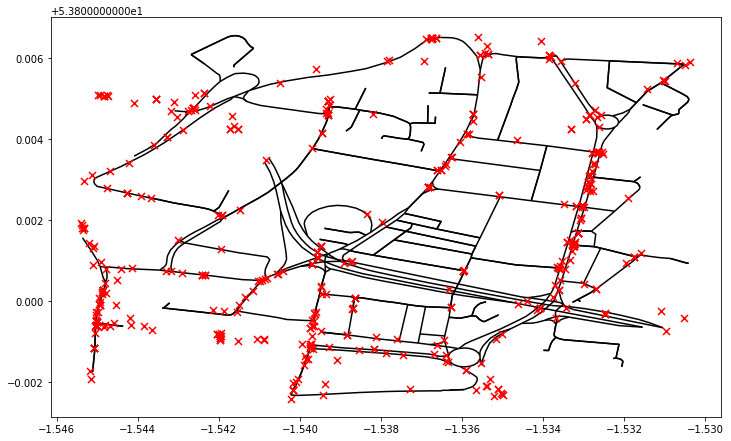

In [22]:
# Show the network
base_network = edges_df.plot(color="k", zorder=0, figsize =(12, 12))
# Get a GeoDataFrame of the non-snapped (real) crime locations to plot on the net
observed_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=False)

# Plot these on the road network
observed_accidents.plot(
    color="r", marker="x",
    markersize=50, zorder=1, ax=base_network)

# plt.savefig('crime_observations_unsnapped')

/home/k21195339/.local/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


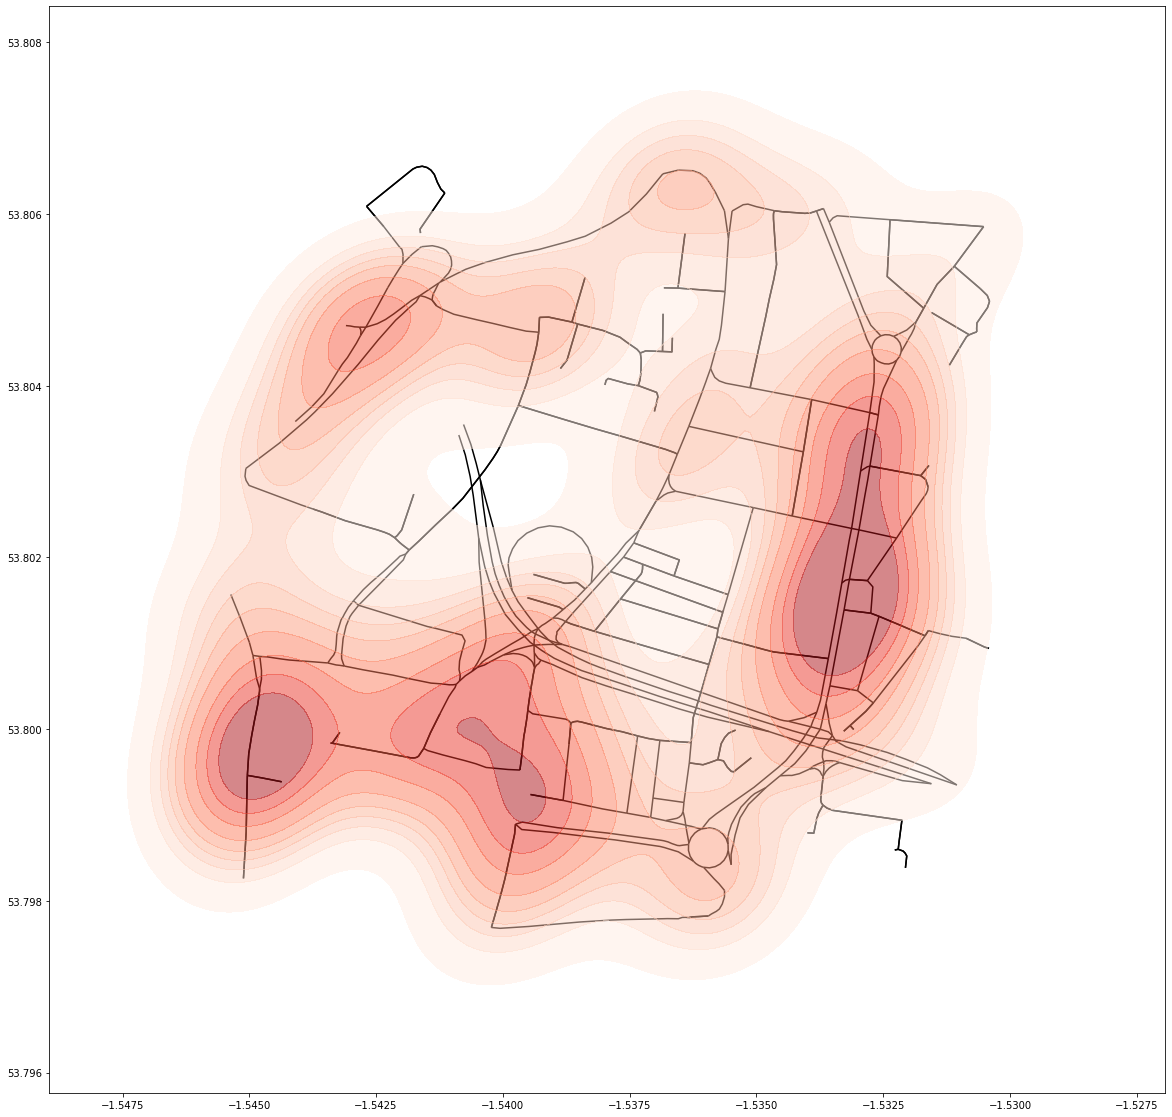

In [23]:
# Create a new figure and axes object
fig, ax = plt.subplots(figsize=(20,20))

# Plot a KDE heatmap of the snapped accidents on the road network
# Increase sensitivity of the heatmap by decreasing the bandwidth
sns.kdeplot(
    x=snapped_accidents.geometry.x,
    y=snapped_accidents.geometry.y,
    cmap='Reds',
    shade=True,
    shade_lowest=False,
    alpha=0.5,
    ax=ax,
    bw_adjust=0.75  # Change this value to adjust the bandwidth
)

# Show the network on the same axes object
edges_df.plot(color="k", zorder=0, ax=ax)

# Display the plot
plt.show()

In [24]:
kres = leeds_points_graph.GlobalAutoK(
    leeds_points_graph.pointpatterns["accidents"],
    nsteps=50, permutations=100
)

In [25]:
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

Density of points in the network (lambda): 1959.0512646311574


In [26]:
print(f"Distances at which density is measured:\n{kres.xaxis}")

Distances at which density is measured:
[0.         0.0004222  0.0008444  0.00126659 0.00168879 0.00211099
 0.00253319 0.00295538 0.00337758 0.00379978 0.00422198 0.00464417
 0.00506637 0.00548857 0.00591077 0.00633296 0.00675516 0.00717736
 0.00759956 0.00802175 0.00844395 0.00886615 0.00928835 0.00971054
 0.01013274 0.01055494 0.01097714 0.01139933 0.01182153 0.01224373
 0.01266593 0.01308812 0.01351032 0.01393252 0.01435472 0.01477691
 0.01519911 0.01562131 0.01604351 0.01646571 0.0168879  0.0173101
 0.0177323  0.0181545  0.01857669 0.01899889 0.01942109 0.01984329
 0.02026548 0.02068768]


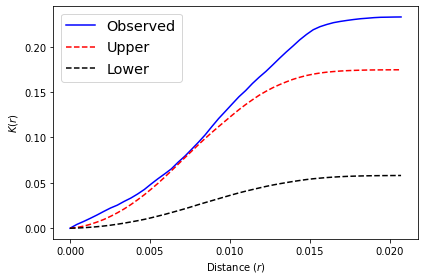

In [27]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

In [28]:
# Get snapped point pattern 
pointpat = leeds_points_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_points_graph.count_per_link(pointpat.obs_to_arc, graph=False)
counts

{(711, 712): 1,
 (618, 619): 1,
 (577, 578): 1,
 (697, 698): 1,
 (732, 733): 3,
 (190, 194): 1,
 (781, 782): 3,
 (288, 289): 3,
 (615, 616): 2,
 (606, 607): 2,
 (957, 958): 4,
 (549, 551): 2,
 (167, 857): 2,
 (431, 432): 1,
 (174, 175): 5,
 (976, 977): 6,
 (887, 888): 1,
 (708, 709): 1,
 (42, 155): 5,
 (963, 964): 1,
 (75, 182): 1,
 (119, 120): 1,
 (983, 984): 2,
 (775, 776): 6,
 (261, 918): 1,
 (529, 672): 5,
 (121, 122): 2,
 (235, 830): 7,
 (33, 799): 1,
 (67, 68): 5,
 (619, 903): 2,
 (91, 709): 2,
 (173, 844): 2,
 (122, 956): 5,
 (152, 843): 2,
 (342, 343): 3,
 (698, 699): 7,
 (54, 981): 3,
 (166, 550): 2,
 (53, 285): 4,
 (858, 859): 1,
 (116, 117): 1,
 (652, 653): 2,
 (488, 489): 1,
 (47, 48): 3,
 (524, 525): 3,
 (289, 549): 22,
 (79, 80): 1,
 (753, 754): 3,
 (665, 666): 3,
 (915, 916): 2,
 (122, 963): 4,
 (588, 589): 1,
 (76, 77): 1,
 (784, 785): 1,
 (912, 913): 1,
 (667, 668): 3,
 (332, 333): 1,
 (480, 609): 9,
 (204, 205): 1,
 (641, 642): 2,
 (363, 364): 3,
 (36, 38): 2,
 (390, 

In [29]:
# Get the weights matrix for edges in the graph (just the adjacency matrix with 1 where edges connect at a node, 0 otherwise)
weights = leeds_points_graph.w_network

In [30]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [31]:
moran = esda.moran.Moran(values, weights)
moran.I

0.1242845669590101

In [32]:
moran.p_sim

0.005

In [33]:
moran.EI
moran.EI_sim

print(moran.EI)

-0.0009372071227741331


Text(0.5, 0, "Moran's I")

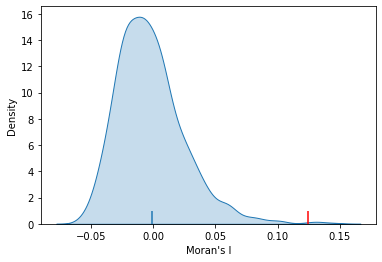

In [34]:
import seaborn as sns

sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

In [35]:
moran.z_norm

4.423455239311521

In [36]:
moran.z_sim

4.596865831778751

In [37]:
snapped_accidents=spaghetti.element_as_gdf(
    leeds_points_graph, pp_name='accidents', snapped=True)

In [38]:
# Find the nearest intersection for each accident
snapped_accidents

snapped_accidents['nearest_link'] = base_network.nearest_link(snapped_accidents.geometry)

# Find the nearest intersection for each accident
intersections = spgh.element_as_gdf(network, network.node_subset('intersection'), 'intersections')
snapped_accidents['nearest_intersection'] = spgh.element_as_gdf(network, intersections,
                                                               'intersections').nearest(snapped_accidents.geometry)

# Calculate the distance of each accident from the nearest intersection
snapped_accidents['distance_to_intersection'] = snapped_accidents.geometry.distance(
    snapped_accidents['nearest_intersection'].values[0])

# Bin the distances into intervals
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]
snapped_accidents['distance_bin'] = pd.cut(snapped_accidents['distance_to_intersection'], bins)

# Count the number of accidents in each interval
accidents_by_distance = snapped_accidents.groupby('distance_bin').size()

# Calculate the proportion of accidents in each interval
accidents_prop = accidents_by_distance / accidents_by_distance.sum()

# Plot the results
accidents_prop.plot(kind='bar')

AttributeError: 'AxesSubplot' object has no attribute 'nearest_link'

## Task C (Voronoi diagrams):

Despite its accidents, the city of Leeds is ideal for organising marathons. The city major would like to organise a day of parallel, simultaneous marathons in different parts of the city. The major would like to maximise the participation of citizens by organising these marathons in diverse locations of the city, dividing the city into various areas (or “cells”) so that every person can join a marathon that is close to their home. Within each of these cells, a path of exactly 42 Km is needed. Assuming that the mayor would like to organise N=10 simultaneous marathons:

1.     Select the initial set of 10 cell seed points. For this, you can use several criteria, such as being far away from frequent accident roads, being close to public transport, being evenly spread, etc. (explain your choice in the report).

2.     Visualise the cells yield by your selection of seed points in a Voronoi diagram

3.     Find 2 or 3 cells for which you can find at least one path (or more, if possible) that is (a) exactly 42 Km long, and (b) finishes at the same point where it starts. Visualise both the cells and the found paths.

4.     Try to extend the previous step to all cells. Can you find at least one such a path for every cell?

5.     If for steps 3-4 there were cells with no such path, what different options could you consider to increase the number of cells that include such paths? (Hint: think about the number and location of seed points; the size of the area under consideration; etc.) Choose one of such options, repeat steps 3-4, and report the results you obtain, explaining your reasoning in the report.

In [38]:
# City with larger size
query_place = 'Leeds, United Kingdom'
full_leeds_graph = ox.graph_from_place(query_place, network_type="all")

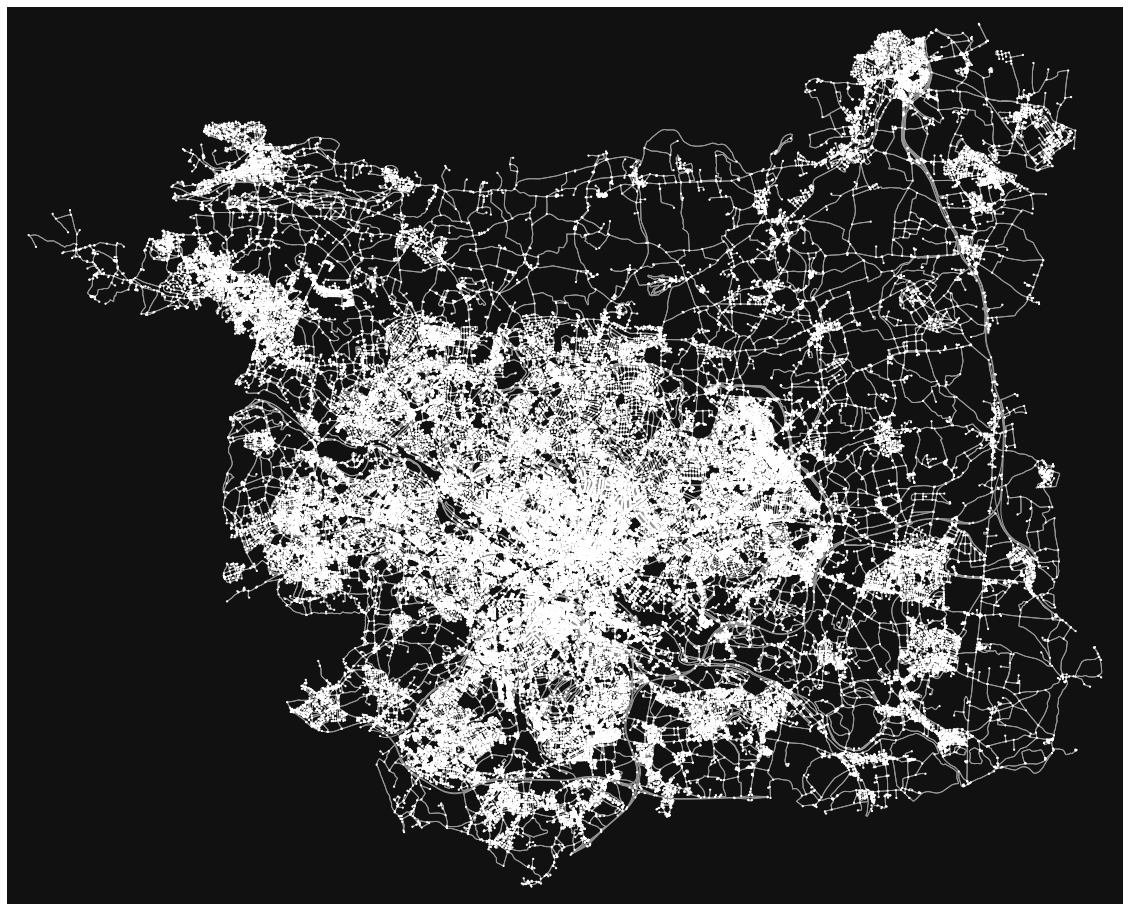

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [39]:
# graph_project = ox.project_graph(query_place_graph)
ox.plot_graph(full_leeds_graph, figsize=(20,20), node_size=5)

In [86]:
NUMBER_OF_SEEDS = 10

all_nodes = list(full_leeds_graph.nodes)
seeds = random.choices(all_nodes, k=NUMBER_OF_SEEDS)

In [87]:
colours = ox.plot.get_colors(NUMBER_OF_SEEDS)

def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

def nearest_seed(node, dist, seeds):
    seed_distances = [(seed, dist[seed][node]) \
        for seed in seeds if node in dist[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge, dist, seeds):
    nearest_to_ends_all = [nearest_seed(edge[0], dist, seeds), nearest_seed(edge[1], dist, seeds)]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

In [100]:
def print_voronoi_graph(G, seeds):
    distances = {seed: nx.single_source_dijkstra_path_length(G, seed, weight='length') for seed in seeds}
    
    edge_nearest_seeds = [nearest_for_edge(edge, distances, seeds) for edge in G.edges]
    # Note that edges not connected to a seed shown in black, so invisible on black background
    edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
    # For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
    node_colours = ['r' if node in seeds else 'w' for node in all_nodes]
    node_sizes = [30 if node in seeds else 0 for node in all_nodes]
    
    ox.plot.plot_graph(full_leeds_graph, figsize=(20,20), edge_color = edge_colours, node_size = node_sizes, node_color = node_colours, bgcolor = 'k', save = True, filepath = 'nvd.png')

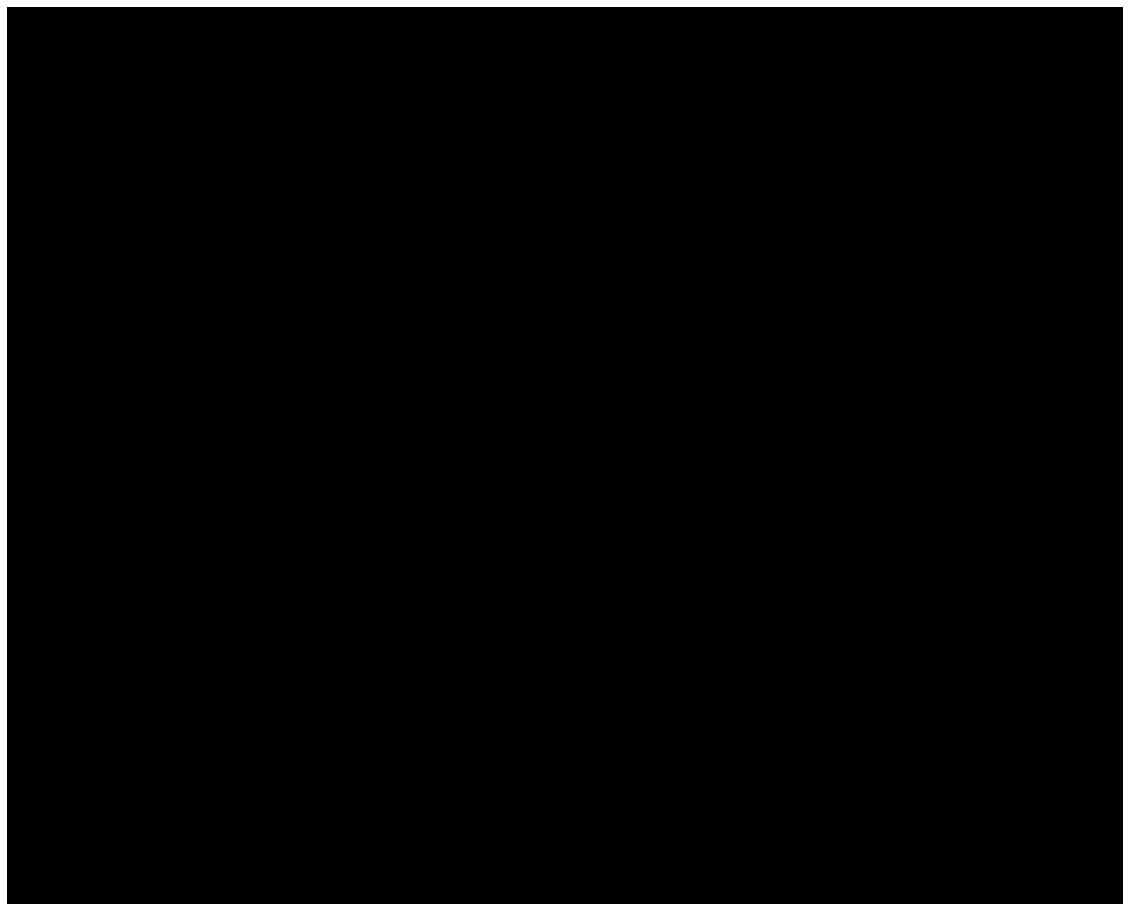

In [101]:
print_voronoi_graph(full_leeds_graph, seeds)

In [90]:
# Load the OSMnx graph data for your area of interest
G = full_leeds_graph

# Create a list of all nodes in the graph
all_nodes = list(G.nodes())
num_seeds
# Randomly select the first seed node
seeds = [np.random.choice(all_nodes)]

# Continue randomly selecting seeds until we have enough
while len(seeds) < NUMBER_OF_SEEDS:
    # Calculate the minimum distance from each node to the existing seed nodes
    distances = []
    for node in all_nodes:
        min_distance = np.inf
        for seed in seeds:
            distance = ox.distance.euclidean_dist_vec(G.nodes[node]['x'], G.nodes[node]['y'], G.nodes[seed]['x'], G.nodes[seed]['y'])
            min_distance = min(min_distance, distance)
        distances.append(min_distance)
    
    # Select the node with the maximum minimum distance as the next seed node
    new_seed = all_nodes[np.argmax(distances)]
    seeds.append(new_seed)

# Print the seed nodes
print(seeds)

[5536087618, 320120350, 411734395, 8434521922, 1652877084, 8175123610, 5788091873, 3703757982, 676623221, 3547383317]


/home/k21195339/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


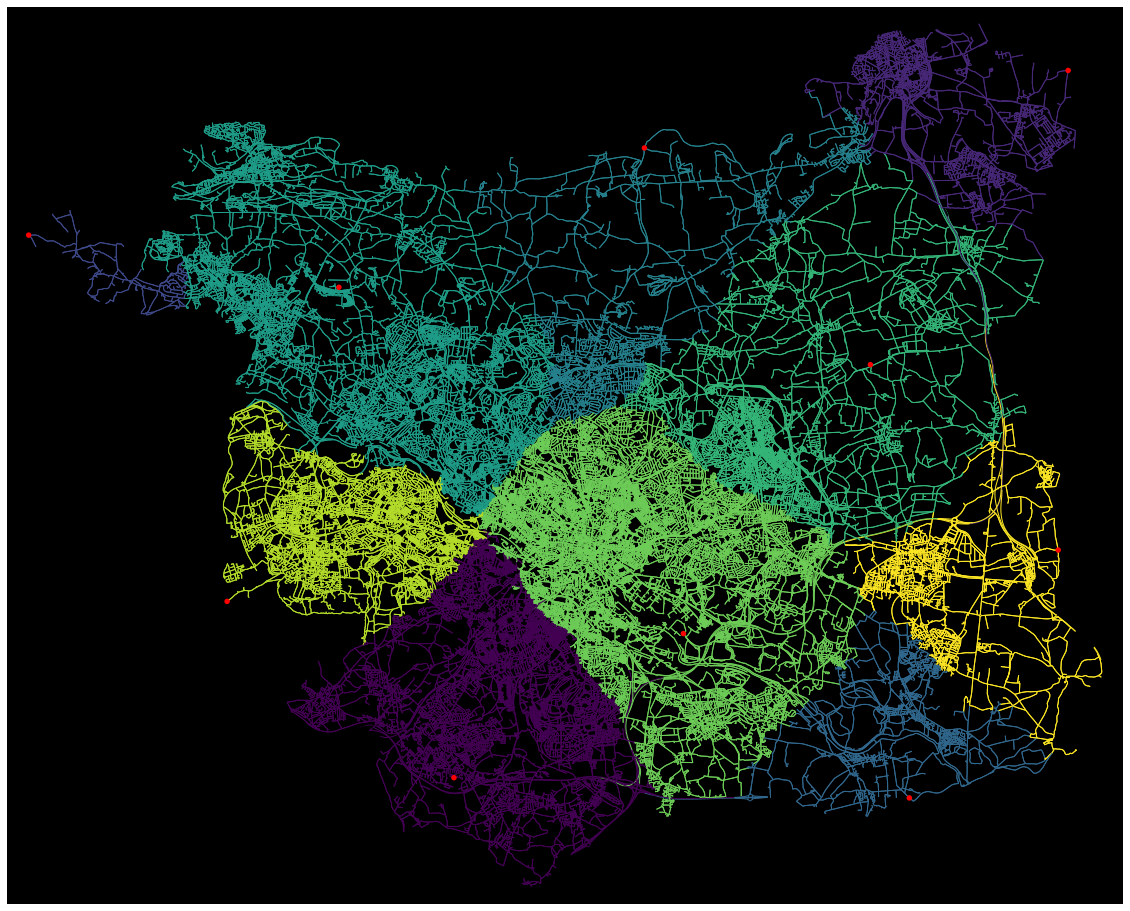

In [91]:
print_voronoi_graph(full_leeds_graph, seeds)

In [93]:
# Calculate the node degree for each node
node_degrees = {}
for node in all_nodes:
    node_degrees[node] = len(list(G.neighbors(node)))

# Sort the nodes by degree in descending order
sorted_nodes = sorted(all_nodes, key=lambda node: node_degrees[node], reverse=True)

# Select the top num_seeds nodes by degree as the seed nodes
seeds = sorted_nodes[:NUMBER_OF_SEEDS]

# Print the seed nodes
print(seeds)

[298034329, 247957025, 298034294, 330054775, 388172962, 664039323, 1624183665, 2018338162, 2018371862, 2018371969]


/home/k21195339/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


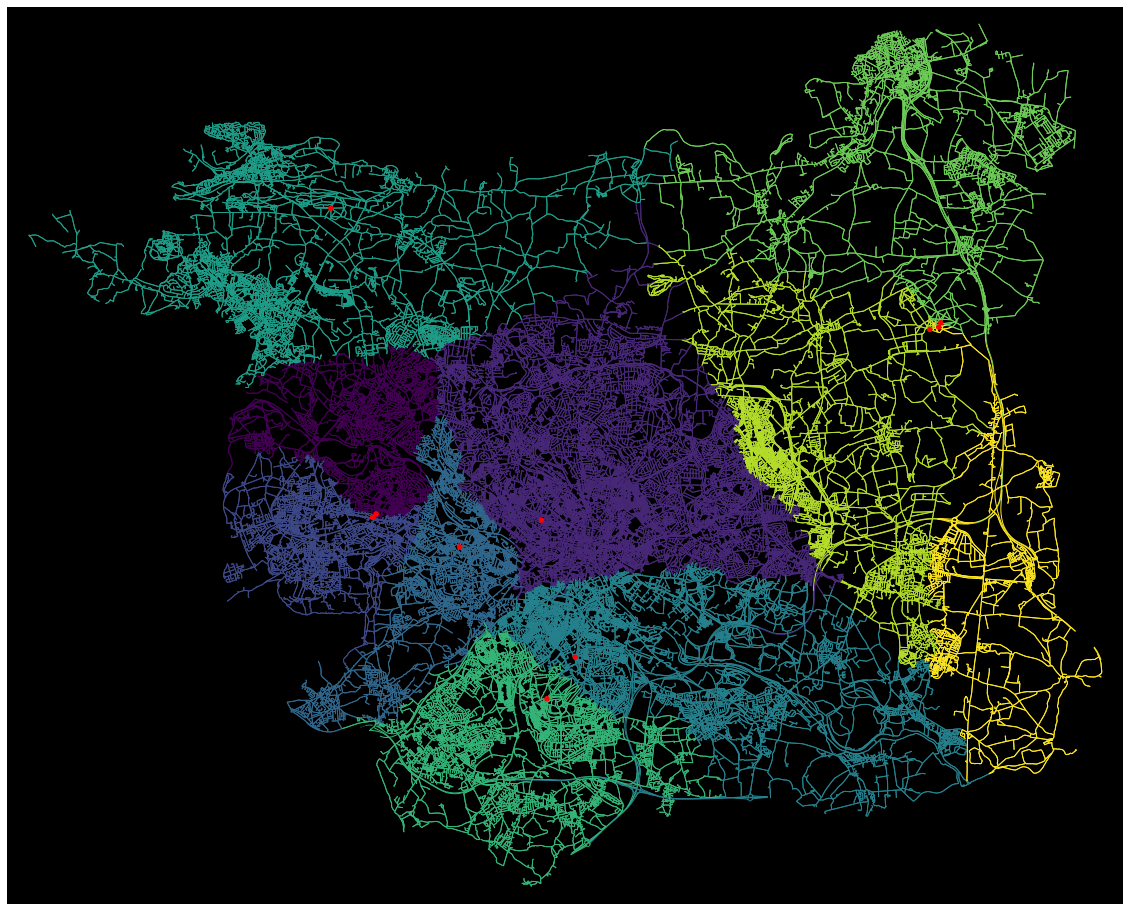

In [94]:
print_voronoi_graph(full_leeds_graph, seeds)

In [49]:
def check_convergence(lengths):
    print(lengths)
    return False
    

In [ ]:
# Initialize a dictionary to hold the assignments of nodes to seeds
assignments = {}

# Initialize a dictionary to hold the total length of each region in terms of edge length
region_lengths = {}

converged = False

# Iterate until convergence
while not converged:
    
    # Calculate the distance from each node to each seed
    distances = {}
    for node in full_leeds_graph.nodes():
        try:
            distances[node] = {seed: nx.shortest_path(full_leeds_graph, source=node, target=seed,method='dijkstra') for seed in seeds}
        except:
            pass
        #distances[node] = {seed: nx.shortest_path(full_leeds_graph, source=node, target=seed,method='dijkstra') for seed in seeds}
    
    print(1)  
    # Assign each node to its closest seed
    for node in full_leeds_graph.nodes():
        closest_seed = np.argmin(distances[node])
        assignments[node] = closest_seed
        
    print(2)
    # Calculate the total length of each region in terms of edge length
    for seed in seeds:
        region_lengths[seed] = 0
    for edge in full_leeds_graph.edges():
        from_seed = assignments[edge[0]]
        to_seed = assignments[edge[1]]
        if from_seed == to_seed:
            region_lengths[from_seed] += full_leeds_graph.edges[edge]['length']
            
    print(3)
    # Optimize the seed assignments
    for seed in seeds:
        neighbors = leeds_neighbored[seed]
        max_gain = 0
        best_neighbor = None
        for neighbor in neighbors:
            old_length = region_lengths[seed] + region_lengths[assignments[neighbor]]
            assignments[neighbor] = seed
            new_length = 0
            for edge in full_leeds_graph.edges():
                from_seed = assignments[edge[0]]
                to_seed = assignments[edge[1]]
                if from_seed == to_seed:
                    new_length += full_leeds_graph.edges[edge]['length']
            gain = new_length - old_length
            if gain > max_gain:
                max_gain = gain
                best_neighbor = neighbor
            assignments[neighbor] = assignments[neighbor] # reset the assignment
        if max_gain > 0:
            assignments[best_neighbor] = seed
    
    # Check for convergence
    converged = check_convergence(region_lengths)

In [ ]:
for u, v, keys, weight in G.edges(data="weight", keys=True):
    if weight is not None:
        # Do something useful with the edges
        pass